This is a notebook designed to be run on the workstation at the Christie. It is, as of 24/06/2023, the most up to date version of the code for Robbie Chambers and Huw McNally's MPhys project. 

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
from shapely.geometry import Point, LineString
from gym import Env, spaces
import time
import pydicom as dcm
import cv2 as cv
import os
import torch
import copy
import math
from scipy import special

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor
from stable_baselines3.common.callbacks import EvalCallback

In [ ]:
# Set GPU device
torch.cuda.set_device(1)

### Load in the patient data

In [ ]:
class MissingROI(Exception):
    pass

In [ ]:
def contains_external(name):
    """
    Returns True if the ROI name matches a given search name, else returns False
    """
    external_names = ["EXTERNAL", "External", "external", "EXT", "Ext", "ext"]
    for string in external_names:
        if(name == string):
            return True
        
    return False

def contains_gtv(name):
    """
    Returns True if the ROI name matches a given search name, else returns False
    """
    gtv_names = ["gtv", "GTV", "Gtv", "gTV"]
    for string in gtv_names:
        if(name == string):
            return True
        
    return False

def contains_ctv_sub(name):
    """
    Returns True if the ROI name matches a given search name, else returns False
    """
    ctv_names = ["CTV70 Sub", "CTV 70 Sub", "CTV70 SUB", "CTV 70 sub", "CTV 70 SUB"]
    for string in ctv_names:
        if(name == string):
            return True
        
    return False

def find_external(structure):
    """
    Checks whether an input file matches a list of possible external ROI names
    """
    roi_num = 0

    while not contains_external(structure.StructureSetROISequence[roi_num].ROIName):
        roi_num += 1
        if roi_num > len(structure.StructureSetROISequence) - 1:
            raise MissingROI("Sorry, external ROI is not contained in this Structure Sequence")
    name = structure.StructureSetROISequence[roi_num].ROIName
    return name

# def find_gtv(structure):
#     """
#     Checks whether an input file matches a list of possible external ROI names
#     """
#     roi_num = 0

#     while not contains_ctv_sub(structure.StructureSetROISequence[roi_num].ROIName):
#         roi_num += 1
#         if roi_num > len(structure.StructureSetROISequence) - 1:
#             roi_num = 0
#             while not contains_gtv(structure.StructureSetROISequence[roi_num].ROIName):
#                 roi_num += 1
#                 if roi_num > len(structure.StructureSetROISequence) - 1:
#                     raise MissingROI("Sorry, CTV SUB / GTV ROI is not contained in this Structure Sequence")
#     name = structure.StructureSetROISequence[roi_num].ROIName
#     return name

def find_gtv(structure):
    """
    Checks whether an input file matches a list of possible external ROI names
    """
    roi_num = 0

    while not contains_gtv(structure.StructureSetROISequence[roi_num].ROIName):
        roi_num += 1
        if roi_num > len(structure.StructureSetROISequence) - 1:
            raise MissingROI("Sorry, GTV ROI is not contained in this Structure Sequence")
    name = structure.StructureSetROISequence[roi_num].ROIName
    return name

def find_ctv_sub(structure):
    """
    Checks whether an input file matches a list of possible external ROI names
    """
    roi_num = 0

    while not contains_ctv_sub(structure.StructureSetROISequence[roi_num].ROIName):
        roi_num += 1
        if roi_num > len(structure.StructureSetROISequence) - 1:
            raise MissingROI("Sorry, CTV SUB ROI is not contained in this Structure Sequence")
    name = structure.StructureSetROISequence[roi_num].ROIName
    return name

In [ ]:
def find_files_with_string(string, path):
    file_paths = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if string in file:
                file_paths.append(os.path.join(root, file))
    return file_paths

def find_dir_with_string(string, path):
    for root, dirs, files in os.walk(path):
        for dir in dirs:
            if string in dir:
                dir_path = os.path.join(root, dir)
                continue
    return dir_path

def find_valid_structure_path(patient):
    file_paths = find_files_with_string("1-1.dcm", patient)
    for file_path in file_paths:
        try:
            with dcm.dcmread(file_path) as struct:
                ext_name = find_external(struct)
                try:
                    cancer_name = find_ctv_sub(struct)
                except MissingROI:
                    cancer_name = find_gtv(struct)
            structure_path = file_path
        
        except AttributeError as e:
            # If we want the dose files we can put something in here
            print("Not a structure file!")
            continue
        
        except MissingROI:
            print("Does not contain the 'External' or 'GTV' ROI")
            continue

        return structure_path, cancer_name, ext_name

def find_valid_data_paths(directory):
    datasets = []
    for patient in os.scandir(directory):
        try:
            rt_simulation = find_dir_with_string("RT SIMULATION", patient)
            structure_path, gtv_name, ext_name = find_valid_structure_path(patient)
            for root, dirs, files in os.walk(rt_simulation):
                    for file in files:
                        if not file.startswith("1-1.dcm"):
                            ct_path = os.path.join(root, file)
                            ct_dir = root
                            break
            datasets.append((ct_dir, ct_path, structure_path, gtv_name, ext_name))
        except TypeError as e:
            print("Weird file alert!!!")
            continue
        except UnboundLocalError:
            print("Another weird fileeeeeeee!!!")
            continue
            
    return datasets

In [ ]:
multi_patient_direction = "/workspaces/MPhys Gamification/HNSCC_215pts/manifest-1679856320086/HNSCC"
my_data = find_valid_data_paths(multi_patient_direction)

In [ ]:
def load_patient(directory: str, CT_fp: str, RS_fp: str, gtv_name: str, ext_name: str):
    """
    Takes a directory containing the CTs, structure file path and list of tuples 
    containing the brain regions in the structure file that are to be read in along
    with their threshholds and their reward weightings. e.g {"External", 70, 0.1}.
    
    Reads in the CT and structure files and creates BrainRegion objects for each
    brain region in the included_regions list which are then returned in an array.
    """
    ################################### Finish ###################################
    # regions = []
    # regions.append(BrainRegion(directory, CT_fp, RS_fp, gtv_name, 0.7))
    # regions.append(BrainRegion(directory, CT_fp, RS_fp, ext_name, 1))
    cancer = BrainRegion(directory, CT_fp, RS_fp, gtv_name, 1.7)
    external = BrainRegion(directory, CT_fp, RS_fp, ext_name, 1)
    return cancer, external

In [ ]:
def load_pseudo(directory: str, CT_fp: str, RS_fp: str, gtv_name: str, ext_name: str):
    """
    Takes a directory containing the CTs, structure file path and list of tuples 
    containing the brain regions in the structure file that are to be read in along
    with their threshholds and their reward weightings. e.g {"External", 71, 1.1}.
    
    Reads in the CT and structure files and creates BrainRegion objects for each
    brain region in the included_regions list which are then returned in an array.
    """
    ################################### Finish ###################################
    # regions = []
    # regions.append(BrainRegion(directory, CT_fp, RS_fp, gtv_name, 1.7))
    # regions.append(BrainRegion(directory, CT_fp, RS_fp, ext_name, 1))
    cancer = pseudoRegion(directory, CT_fp, RS_fp, gtv_name, 1.7)
    external = pseudoRegion(directory, CT_fp, RS_fp, ext_name, 1)
    return cancer, external

In [ ]:
class pseudoRegion():
    """ Instantiation of the BrainRegion object. Takes directory of the ct files, 
    an arbitrary ct file path, the structure file path and the names of the region
    contour

    Args:
        object (_type_): _description_
    """
    def __init__(self, directory, CT_path, struct_path, contour_name, threshold):
        self.directory = directory
        self.ct_path = CT_path
        self.structure = dcm.dcmread(struct_path)
        self.contour_name = contour_name
        self.threshold = threshold
        self.roi_num = self.get_roi_index(contour_name)
        self.coordinate_stack, self.r_uids = self.get_coordinate_stack()
        
    def get_roi_index(self, roi_name):
        """
        Takes a string and outputs the roi location within the structure file of
        corresponding contour e.g CTV 71, brainstem etc.
        """
        roi_num = 0
        while roi_name != self.structure.StructureSetROISequence[roi_num].ROIName:
            roi_num += 1
            if roi_num > len(self.structure.StructureSetROISequence) - 1:
                raise Exception(f"Sorry, {roi_name} is not contained in this Structure Sequence")
        print(f"The ROI index for {roi_name} is {roi_num}")
        return roi_num

    def get_coordinate_stack(self):
        """
        Returns the set of contours present in a 2D CT scan.
        """
        roi_contours = []
        referenced_uids = []
        for slice in os.scandir(self.directory):
            if slice.is_file():
                with dcm.dcmread(slice.path) as ds_ct:
                    slice_id = ds_ct.SOPInstanceUID
                    # Plotting iteratively through all the contours of one ROI on one CT scan
                    for j in range(len(self.structure.ROIContourSequence[self.roi_num].ContourSequence)):
                        for k in range(len(self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].ContourImageSequence)):
                            if self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].ContourImageSequence[k].ReferencedSOPInstanceUID == slice_id:
                                point_number = self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].NumberOfContourPoints

                                contour_array_old_coords = np.reshape(self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].ContourData, (point_number, 3))
                                new_x = (contour_array_old_coords[:,0] - ds_ct.ImagePositionPatient[0])/ ds_ct.PixelSpacing[0]
                                new_y = (contour_array_old_coords[:,1] - ds_ct.ImagePositionPatient[1])/ ds_ct.PixelSpacing[1]
                                #ct_z_coord = contour_array_old_coords[:,2]
                                contour_data = np.array([new_x, new_y])
                                roi_contours.append(contour_data)
                                referenced_uids.append(slice_id)
                                continue

        return roi_contours, referenced_uids

In [ ]:
class SearchBot():
    def __init__(self):
        self.min_x_learn = 512
        self.max_x_learn = 0
        self.min_y_learn = 512
        self.max_y_learn = 0

    def find_max_search_space(self, region):
        """
        Finds maximum boundaries of a Brain Region.
        """
        for k in range(len(region.coordinate_stack)):
            self.min_x_learn = min(region.coordinate_stack[k][0].min(), self.min_x_learn)
            self.max_x_learn = max(region.coordinate_stack[k][0].max(), self.max_x_learn)
            self.min_y_learn = min(region.coordinate_stack[k][1].min(), self.min_y_learn)
            self.max_y_learn = max(region.coordinate_stack[k][1].max(), self.max_y_learn)
            
    def remove_empty_contours(self, data):
        """Checks whether the external or cancer contour stacks are empty and if so,
        removes them from the input data

        Args:
            data (list): list of patients, where each patient contains file paths for directory, Ct and structure
        """
        index = 0
        for patient in data:
            try:
                cancer = pseudoRegion(patient[0], patient[1], patient[2], patient[3], 0.7)
                external = pseudoRegion(patient[0], patient[1], patient[2], patient[4], 1)
                if cancer.coordinate_stack == [] or external.coordinate_stack == []:
                    data.pop(index)
                else:
                    index += 1
            except AttributeError:
                data.pop(index)
                continue
        return data


In [ ]:
search_bot = SearchBot()
search_bot.remove_empty_contours(my_data)

index = 0

for patient in my_data:
    try:
        cancer, _ = load_pseudo(patient[0],patient[1],patient[2],patient[3],patient[4])

        search_bot.find_max_search_space(cancer)
        print(f"{search_bot.min_x_learn, search_bot.max_x_learn, search_bot.min_y_learn, search_bot.max_y_learn}")
        index +=1
    except AttributeError:
        my_data.pop(index)
        continue


### Load in the environment, Brain region and Beam classes

In [ ]:
class ParallelBeamEnv(Env):
    def __init__(self):
        super(ParallelBeamEnv, self).__init__()
        self.cancer = CANCER
        self.external = EXTERNAL
        self.learn_space = LEARN_SPACE
        self.x_min = self.learn_space[0]
        self.x_max = self.learn_space[1]
        self.y_min = self.learn_space[2]
        self.y_max = self.learn_space[3]
        self.search_space = self.bound_search_space(self.cancer)
        self.beam = Beam(self.search_space) 
        self.action_space = spaces.MultiDiscrete([3,3,3,2])# Position of spot, angle of beam, beam intensity
        self.x_size = self.x_max - self.x_min
        self.y_size = self.y_max - self.y_min
        self.observation_shape = (self.y_size, self.x_size)
        self.target_dose = 0.7 # Dose prescription measured in Gy
        self.canvas = np.zeros((512,512), dtype=np.float32)
        self.target_mask = self.target_dose * np.array(self.cancer.boolean_map[self.y_min:self.y_max, self.x_min:self.x_max], dtype=np.float32)
        self.observation_space = spaces.Dict({
            "position": spaces.Box(low = np.array([0,0]), 
                                    high = np.array(self.observation_shape),
                                    dtype=int),
            "dose distribution": spaces.Box(low = np.zeros(self.observation_shape),
                                            high = np.ones(self.observation_shape),
                                            dtype=np.float32),
            "target mask": spaces.Box(low = np.zeros(self.observation_shape),
                                        high = np.ones(self.observation_shape),
                                        dtype=np.float32)})
        self.state = {
            "position": [0, 0],
            "dose distribution": self.canvas[self.y_min:self.y_max, self.x_min:self.x_max],
            "target mask": self.target_mask}
        self.treatment_period = 1024 # Number of steps per learning perdiod
        self.theta_resolution = 45 # How many degrees changed per step, this has to be 45 for use with our current dose model
        self.default_dose = 0.1 # Default amount to be used until variable dosing is implemented. Can also be a reference value for decrete choice dosing e.g choices are 0, 0.25, 0.5, 1, 1.5, 2, 2.5x reference dose when choosing
        self.step_size = 3
        self.reward_stack = self.calculate_reward_stack()
        self.reward_map = self.reward_stack[0]
        self.update_reward_map()
        self.alpha = 0.0005
        self.beta = 0.0005
        self.step_without_dose = 0

    def set_patient(self, cancer, external):
        """ Changes the patient that the environment is using.

        Args:
            cancer (BrainRegion): the brain region object for the cancer of the new patient
            external (BrainRegion): the brain region object for the external of the new patient
        """
        self.cancer = cancer
        self.external = external
        self.reset()
    
    def set_learn_space(self, min_x, max_x, min_y, max_y):
        """Sets the bounds for the learn space - the size of the space returned in the step function

        Args:
            min_x (double): minimum x coordinate
            max_x (double): maximum x coordinate
            min_y (double): minimum y coordinate
            max_y (double): maximum y coordinate
        """
    def step(self, action):
        """
        Applies the action chosen by the Agent. Calculates 'reward'. Updates the
        'state'. Decreases the treatment period by 1. Updates the 'done' status.
        Returns 'info'. 
        """
        # Initially set reward to zero so if no action taken, reward does not carry over from previous step
        reward = 0
        # Check if plan is done
        if self.treatment_period <= 0: 
            done = True
        else:
            done = False
        
        # Translational Shift
        del_yx = (action[0:2] - 1) * self.step_size # The 1 here can be changed to change step size
        self.beam.move(del_yx[0], del_yx[1])
        self.state["position"] = np.array([self.beam.y-self.y_min, self.beam.x-self.x_min])
        
        # Angular Shift
        del_theta = (action[2] - 1) * self.theta_resolution
        self.beam.rotate(del_theta)

        # Apply_dose and calculate corresponding reward. Penalise 'no dosing'.
        if action[3] == 1:
            reward = self.apply_bortfeld_dose()# Change the dosing methods here
            self.state["dose distribution"] = self.canvas[self.y_min:self.y_max, self.x_min:self.x_max]
            self.step_without_dose = 0

        else:
            self.step_without_dose += 1
            
        if self.step_without_dose > 9:# Might need tuning to allow more steps, but this is plenty for now
            reward -= 1
        
        # Evaluate state of the environment
        bias = self.alpha * np.sum(self.target_mask) + self.beta * np.sum(self.target_mask**2)
        
        reward += (bias + self.evaluate_state())
        
        # Check for overdosing
        if (np.max(self.canvas) > 0.99): # 0.99 to allow for slight dosing over the cancer target dose (0.7 currently)
            reward -= 10
            done = True
        
        # Reduce treatment period by 1; Retaining treatment period approach in case method changes in the future
        self.treatment_period -= 1

        info = {}

        return self.state, reward, done, info

    def reset(self):
        """
        Resets environment to initial state. Currently set to zeros but could also
        be set to either base CT image. This will also have to change if we move
        from 'Box' to 'Dict' space. 
        """
        # Random Slice
        slice_number = np.random.randint(0, high=len(self.cancer.r_uids))
        self.cancer.slice_number = slice_number
        self.match_uid(self.cancer, self.external)
        self.cancer.update_slices()
        self.external.update_slices()
        self.beam.update_search_space(self.cancer.contour_map)
        self.target_mask = self.target_dose * np.array(self.cancer.boolean_map[self.y_min:self.y_max, self.x_min:self.x_max], dtype=np.float32)
        self.canvas = np.zeros((512,512), dtype=np.float32)
        # If other brain region objects added as vector, can iterator through them here

        self.update_reward_map()
        self.beam.x = np.random.randint(self.beam.x_min, self.beam.x_max)
        self.beam.y = np.random.randint(self.beam.y_min, self.beam.y_max)

        self.treatment_period = 1024
        self.state = {
            "position": np.array([self.beam.y-self.y_min, self.beam.x-self.x_min], dtype=int),
            "dose distribution": self.canvas[self.y_min:self.y_max, self.x_min:self.x_max],
            "target mask": self.target_mask}
        
        return self.state
    
    def evaluate_state(self):
        # Calculate dose conformity and dose homogeneity
        conformity = -np.sum(np.abs(self.canvas[self.y_min:self.y_max, self.x_min:self.x_max] - self.target_mask))
        homogeneity = -np.sum((self.canvas[self.y_min:self.y_max, self.x_min:self.x_max]  - self.target_mask)**2)

        # Calculate the penalty for delivering dose to critical structures
        # To be inplemented when more BrainRegions are passed to the environment
        
        # Combine the metrics with weights alpha and beta, with a distance-based incentive as well.
        # Can replace '/1000' in distance metric by another weighting factor 
        reward = self.alpha * conformity + self.beta * homogeneity + (self.cancer.distance_map[self.beam.y, self.beam.x]/1000) 
                # + self.theta * critical_structure_penalty - for when critical structures are added

        return reward

    def render(self, mode = "human"):
        """
        Renders the dosing information of the AI upon a CT image.
        """
        assert mode in ["human", "rgb_array", "cancer_contour"], "Invalid mode, must be either \"human\" or \"rgb_array\" or \"cancer_contour\""
        if mode == "human":
            plt.imshow(self.canvas)
            plt.savefig("LatestDose")
            return None
    
        elif mode == "rgb_array":
            return self.canvas
        
        elif mode == "cancer_contour":
            return self.cancer.boolean_map
            

    def is_beam_over_cancer(self):
        """
        Checks if the whole beam is over the cancer contour and if the dose
        exceeds the maximum.

        NOTE: Redundant, or soon to be so.
        """
        x = self.beam.x
        y = self.beam.y        
        beam_over_cancer = self.cancer.boolean_map[(y-1):(y+2),(x-1):(x+2)]
        dose = np.max(self.canvas[(y-1):(y+2),(x-1):(x+2)])
        if (np.sum(beam_over_cancer) == 9) and (dose < 0.7): # Just a placeholder for the dose limit
            return True
        else:
            return False

    def apply_dose(self):
        """
        Applies dose (currently just a fixed amount) at given angle and position.
        Currently just going to place 3x3 dose centered on beam position in order
        to implement proof of concept. Then can increase levels of complexity
        from there.
        """
        square_dose = self.default_dose * np.ones((3,3))
        x = self.beam.x
        y = self.beam.y
        dose_overlap = np.sum(self.reward_map[(y-1):(y+2),(x-1):(x+2)] * square_dose)
        normalised_reward = dose_overlap / (9 * self.default_dose)
        self.canvas[(y-1):(y+2),(x-1):(x+2)] += square_dose
        return normalised_reward

    def apply_bortfeld_dose(self):
        """
        Creates a line of a given thickness between two points and applies a 
        custom gradient to said line (function of distance along the line).
        Then calculates a normalised reward based on the overlap of dose and
        contour.
        """
        x = self.beam.x
        y = self.beam.y
        theta = self.beam.theta        
        
        radius = 2
        n=0
        increments = np.array([])

        if theta == 0:
            # Move in a straight line in y-direction
            if self.within_patient(y+n, x):
                # Move until the beam exits the patient (apprximating 0 attentuation outside the patient)
                while(self.within_patient(y+n, x)):
                    increments = np.append(increments, n)
                    n += 1
                # Record distance (depth) into patient
                depth = np.copy(n)
                n = 0
                # Calculate values at each point along the line using the Bortfeld approximation
                values = self.calculate_bortfield_gradient(depth - increments, increments[-1])
                # Increment the canvas with each value along the line
                for value in values:
                    self.canvas[y+n,x-radius:x+radius+1] += value
                    n += 1

        elif theta == 180 & self.within_patient(y-n,x):
            while(self.within_patient(y-n,x)):
                increments = np.append(increments, n)
                n += 1
            depth = np.copy(n)
            n = 0
            values = self.calculate_bortfield_gradient(depth - increments, depth)
            for value in values:
                self.canvas[y-n,x-radius:x+radius+1] += value
                n += 1

        elif theta == 90 & self.within_patient(y,x+n):
            while(self.within_patient(y,x+n)):
                increments = np.append(increments, n)
                n += 1
            depth = np.copy(n)
            n = 0
            values = self.calculate_bortfield_gradient(increments, depth)
            for value in values:
                self.canvas[y-radius:y+radius+1,x+n] += value
                n += 1

        elif theta == 270 & self.within_patient(y,x-n):
            while(self.within_patient(y,x-n)):
                increments = np.append(increments, n)
                n += 1
            depth = np.copy(n)
            n = 0
            values = self.calculate_bortfield_gradient(depth - increments, depth)
            for value in values:
                self.canvas[y-radius:y+radius+1,x-n] += value
                n += 1

        elif theta < 90 or theta > 270:
            m = np.rint(np.tan(theta*np.pi/180))
            if self.within_patient(y+n,int(x+m*n)):
                while(self.within_patient(y+n,int(x+m*n))):
                    distance = n * np.sqrt(1 + m**2)
                    increments = np.append(increments, distance)
                    n += 1
                depth = np.copy(distance)
                n = 0
                values = self.calculate_bortfield_gradient(depth - increments, depth)
                for value in values:
                    for r in range(2*radius+1):
                        k = r - radius
                        self.canvas[y+n-k, int(x+m*(n+k))] += value
                    for r in range(2*radius):
                        k = r - radius
                        self.canvas[y+n+k, int(x+m*(n-k-1))] += value
                    n += 1

        elif theta > 90 and theta < 270:
            m = np.rint(np.tan(theta*np.pi/180))
            if self.within_patient(y-n,int(x-m*n)):
                while(self.within_patient(y-n,int(x-m*n))):
                    distance = n * np.sqrt(1 + m**2)
                    increments = np.append(increments, distance)
                    n += 1
                depth = np.copy(distance)
                n = 0
                values = self.calculate_bortfield_gradient(depth - increments, depth)
                for value in values:
                    for r in range(2*radius+1):
                        k = r - radius
                        self.canvas[y-n-k,int(x-m*(n-k))] += value
                    for r in range(2*radius):
                        k = r - radius
                        self.canvas[y-n+k, int(x-m*(n+k+1))] += value
                    n += 1

        return 0
    
    def calculate_bortfield_gradient(self, distance, range):
        # R0 = 13.5   #range
        sigma = 0.27    #range straggling sigma
        epsilon = 0.2   #low energy contamination
        p = 1.77    #exponent of range-energy relationship
        if range == 0:
            return [0]
        out = 0.05*0.65*(self.cyl_gauss(-1/p,(distance-range)/sigma)+sigma*(0.01394+epsilon/range)*self.cyl_gauss(-1/p-1,(distance-range)/sigma))
        return out
    
    def cyl_gauss(self, a, x):
        "Calculate product of Gaussian and parabolic cylinder function"
        y = np.copy(x)
        branch = -12.0   #for large negative values of the argument we run into numerical problems, need to approximate result
        x1 = x[np.where(x<branch)]
        y1 = math.sqrt(2*math.pi)/special.gamma(-a)*(-x1)**(-a-1)
        y[np.where(x<branch)] = y1

        x2 = x[np.where(x>=branch)]
        y2a = special.pbdv(a,x2)[0]     #special function yielding parabolic cylinder function, first array [0] is function itself
        y2b = np.exp(-x2*x2/4)
        y2 = y2a*y2b

        y[np.where(x>=branch)] = y2

        return y

    def bound_search_space(self, region):
        """
        Runs through each element in binary map for each slice in a region and
        outputs the maximum and minimum boundaries for each contour region.
        """
        min_x = 512
        max_x = 0
        min_y = 512
        max_y = 0
        for k in range(len(region.binary_stack)):
            for i in range(512):
                for j in range(512):
                    if region.binary_stack[k][j,i] == 1:
                        if i < min_x:
                            min_x = i
                        if i > max_x:
                            max_x = i
                        if j < min_y:
                            min_y = j
                        if j > max_y:
                            max_y = j

        return (int(min_x), int(max_x), int(min_y), int(max_y))

    def within_cancer(self, j, i):
        """
        Returns a True if the coordinates are within the contour, else returns
        False.
        """
        
        if max(j,i) > 512 or min(j,i) < 0:
            return False
        elif self.cancer.contour_map[j,i] == 1:
            return True
        else:
            return False

    def within_patient(self, j, i):
        """
        Returns a True if the coordinates are within the contour, else returns
        False.
        """
        if max(j,i) > 512 or min(j,i) < 0:
            return False
        elif self.external.contour_map[j,i] == 1:
            return True
        else:
            return False
    
    def calculate_reward_stack(self):
        """
        Calculates a 3D 
        """
        reward_arrays = []
        
        for i in range(len(self.cancer.boolean_stack)):
            self.cancer.slice_number = i
            self.match_uid(self.cancer, self.external)
            self.cancer.update_slices()
            self.external.update_slices()
            ith_reward_map = self.calculate_reward_map()
            reward_arrays.append(ith_reward_map)
        reward_stack = np.stack(reward_arrays)
        return reward_stack

    def calculate_reward_map(self):
        """
        Calculates a reward map that priritises the cancer contour.
        """
        reward_map = np.zeros((512,512))
        # Calculates lowest hierachy first
        reward_map[self.external.boolean_stack[self.external.slice_number]] = -1

        # Calculates highest hierachy last
        reward_map[self.cancer.boolean_stack[self.cancer.slice_number]] = 1

        return reward_map
    
    def update_reward_map(self):
        """
        Updates the reward map to the givn slice index.
        """
        self.reward_map = self.reward_stack[self.cancer.slice_number]

    def match_uid(self, region_1, region_2):
        """
        Takes region and a slice index of that region and finds the 
        corresponding slice in a second given region using referenced UID
        matching. If a match is found it updates the second region's slice 
        number.
        """
        slice_id = region_1.r_uids[region_1.slice_number]
        for i in range(len(region_2.r_uids)):
            if region_2.r_uids[i] == slice_id:
                region_2.slice_number = i
                return None
                
        raise Exception(f"Slice {region_1.slice_number} from {region_1.contour_name} could not be matched with {region_2.contour_name}.")


In [ ]:
class Beam(object):
    def __init__(self, contour_region):
        (self.x_min, self.x_max, self.y_min, self.y_max) = contour_region
        self.x = self.x_min
        self.y = self.y_min
        self.theta = 0
        self.distance_from_cancer = 0
        self.distance_from_cord = 0

    def get_position(self):
        return (self.y, self.x)

    def move(self, del_y, del_x):
        """
        Moves the x,y values by some prescribed amount. The position is then 
        bounded by the values set by the observation space.
        """
        self.x += del_x
        self.y += del_y

        self.x = self.bound(self.x, self.x_min, self.x_max)
        self.y = self.bound(self.y, self.y_min, self.y_max)

    def rotate(self, del_theta):
        """
        Increases the value of theta in the anti-clockwise direction. Measured 
        in degrees, modular(360). 
        """
        self.theta = (self.theta + del_theta)%360

    def bound(self, n, minn, maxn):
        """
        Bounds a given number, n, between some given minimum and maximum, 
        (minn, maxn). If n exceeds the boundary, returns the closest allowed
        value.
        """
        return max(min(maxn,n), minn)

    def update_search_space(self, contour_map):
        """
        Runs through each element in binary map
        """
        min_x = 512
        max_x = 0
        min_y = 512
        max_y = 0
        for i in range(512):
            for j in range(512):
                if contour_map[j,i] == 1:
                    if i < min_x:
                        min_x = i
                    if i > max_x:
                        max_x = i
                    if j < min_y:
                        min_y = j
                    if j > max_y:
                        max_y = j

        (self.x_min, self.x_max, self.y_min, self.y_max) = (min_x, max_x, min_y, max_y)

    def find_proton_energy():
        """
        Finds the proton energy required to place the Bragg peak of the spot at
        the required location in the brain given the location of the beam
        """
    def calculate_dose_gradient(self, distance):
        """
        A WET approximation calculation to give the intensity of dose as a
        function of distance from beam spot
        """
        return 0.1 * np.exp(-(distance/4)**2)


In [ ]:
class BrainRegion(object):
    """ Instantiation of the BrainRegion object. Takes directory of the ct files, 
    an arbitrary ct file path, the structure file path and the names of the region
    contour

    Args:
        object (_type_): _description_
    """
    def __init__(self, directory, CT_path, struct_path, contour_name, threshold):
        self.directory = directory
        self.ct_path = CT_path
        self.structure = dcm.dcmread(struct_path)
        self.contour_name = contour_name
        self.threshold = threshold
        self.roi_num = self.get_roi_index(contour_name)
        self.coordinate_stack, self.r_uids = self.get_coordinate_stack() # This is indexed [x,y]
        self.slice_number = 0
        self.contour_coords = self.map_contour_to_ct(self.roi_num) # This is indexed [x,y]
        self.boolean_map, self.contour_map, self.distance_map = self.create_contour_map(self.contour_coords)
        self.boolean_stack, self.binary_stack, self.distance_stack = self.get_contour_stack()

    def get_roi_index(self, roi_name):
        """
        Takes a string and outputs the roi location within the structure file of
        corresponding contour e.g CTV 70, brainstem etc.
        """
        roi_num = 0
        while roi_name != self.structure.StructureSetROISequence[roi_num].ROIName:
            roi_num += 1
            if roi_num > len(self.structure.StructureSetROISequence) - 1:
                raise Exception(f"Sorry, {roi_name} is not contained in this Structure Sequence")
        print(f"The ROI index for {roi_name} is {roi_num}")
        return roi_num

    def get_coordinate_stack(self):
        """
        Returns the set of contours present in a 2D CT scan.
        """
        roi_contours = []
        referenced_uids = []
        for slice in os.scandir(self.directory):
            if slice.is_file():
                with dcm.dcmread(slice.path) as ds_ct:
                    slice_id = ds_ct.SOPInstanceUID
                    # Plotting iteratively through all the contours of one ROI on one CT scan
                    for j in range(len(self.structure.ROIContourSequence[self.roi_num].ContourSequence)):
                        for k in range(len(self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].ContourImageSequence)):
                            if self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].ContourImageSequence[k].ReferencedSOPInstanceUID == slice_id:
                                point_number = self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].NumberOfContourPoints

                                contour_array_old_coords = np.reshape(self.structure.ROIContourSequence[self.roi_num].ContourSequence[j].ContourData, (point_number, 3))
                                new_x = (contour_array_old_coords[:,0] - ds_ct.ImagePositionPatient[0])/ ds_ct.PixelSpacing[0]
                                new_y = (contour_array_old_coords[:,1] - ds_ct.ImagePositionPatient[1])/ ds_ct.PixelSpacing[1]
                                #ct_z_coord = contour_array_old_coords[:,2]
                                contour_data = np.array([new_x, new_y])
                                roi_contours.append(contour_data)
                                referenced_uids.append(slice_id)
                                continue

        return roi_contours, referenced_uids

    def get_contour_stack(self):
        """
        Returns a 3D stack of contours in binary and boolean data types.
        """
        binary_arrays = []
        boolean_arrays = []
        distance_arrays = []
        for i in range(len(self.coordinate_stack)):
            ith_boolean, ith_binary, ith_distance = self.create_contour_map(self.coordinate_stack[i])
            binary_arrays.append(ith_binary)
            boolean_arrays.append(ith_boolean)
            distance_arrays.append(ith_distance)

        binary_stack = np.stack(binary_arrays)
        boolean_stack = np.stack(boolean_arrays)
        distance_stack = np.stack(distance_arrays)
        
        return boolean_stack, binary_stack, distance_stack

    def map_contour_to_ct(self, roi_num):
        """
        Maps the list of contour values to (3,n) dimensional array of x,y,z
        coords that match CT space.
        """
        with dcm.dcmread(self.ct_path) as ct_file:
            no_points = self.structure.ROIContourSequence[roi_num].ContourSequence[self.slice_number].NumberOfContourPoints
            contour_array_old_coords = np.reshape(np.array(self.structure.ROIContourSequence[roi_num].ContourSequence[self.slice_number].ContourData),
                                                (no_points, 3))
            patient_pos_x = np.full(np.shape(contour_array_old_coords[:,0]), float(ct_file.ImagePositionPatient[0]))
            patient_pos_y = np.full(np.shape(contour_array_old_coords[:,1]), float(ct_file.ImagePositionPatient[1]))
            new_x = (contour_array_old_coords[:,0] - patient_pos_x) / float(ct_file.PixelSpacing[0])
            new_y = (contour_array_old_coords[:,1] - patient_pos_y) / float(ct_file.PixelSpacing[1])
            #ct_z_coord = contour_array_old_coords[:,2]
            contour_data = np.array([new_x, new_y]) #np.array([new_x, new_y, ct_z_coord])

        return contour_data

    def create_contour_map(self, contour):
        """
        Takes a list of x,y coordinates and creates a map of size (512,512)
        containing the contour. The map has values of -1 outside the contour, 0 
        on the contour and +1 inside the contour.
        """

        x_vals = contour[0,:]
        y_vals =  contour[1,:]
        contour_xy = list(map(lambda x, y:(int(np.rint(x)),int(np.rint(y))), x_vals, y_vals))

        src = np.zeros((512, 512), dtype=np.uint8)
        num_points = len(x_vals)

        for i in range(num_points):
            cv.line(src, contour_xy[i], contour_xy[(i+1)%num_points], ( 255 ), 3)
        # Get the contours
        contours, hierarchy = cv.findContours(src, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        
        boolean_map = np.empty(src.shape, dtype=bool)
        binary_map = np.empty(src.shape)
        
        for i in range(src.shape[0]):
            for j in range(src.shape[1]):
                if cv.pointPolygonTest(contours[0], (i,j), False)>0:
                    binary_map[j,i] = 1
                    boolean_map[j,i] = True
                else:
                    binary_map[j,i] = -1
                    boolean_map[j,i] = False

        raw_dist = np.empty(src.shape)
        for i in range(src.shape[0]):
            for j in range(src.shape[1]):
                if cv.pointPolygonTest(contours[0], (i,j), True) > 0:
                    raw_dist[j,i] = 0
                else:
                    raw_dist[j,i] = cv.pointPolygonTest(contours[0], (i,j), True)
        
        return boolean_map, binary_map, raw_dist

    def update_slices(self):
        """
        Updates the active slice in the brain regions (to the one chosen in the 
        reset method). 
        """
        self.boolean_map = self.boolean_stack[self.slice_number]
        self.contour_map = self.binary_stack[self.slice_number]
        self.distance_map = self.distance_stack[self.slice_number]

### Main Code

Set up variables

In [ ]:
num_processers = 16 # Number of processes to use
n_timesteps = 500000
logdir = "new_logdir"

In [ ]:
LEARN_SPACE = [int(search_bot.min_x_learn), int(search_bot.max_x_learn), int(search_bot.min_y_learn), int(search_bot.max_y_learn)]
CANCER, EXTERNAL = load_patient(my_data[0][0], my_data[0][1], my_data[0][2], my_data[0][3], my_data[0][4])

The ROI index for CTV 70 sub is 6
The ROI index for external is 25


In [ ]:
print(LEARN_SPACE)

[175, 337, 68, 297]


In [ ]:
#model = PPO.load("/workspaces/MPhys Gamification/modeldir/conformal_multi_patient_23.zip")
env = ParallelBeamEnv()
done = False
rewards = 0
snapshots = []
cancer_contours = []
actions = [np.array([1,1,1,1]),
           np.array([1,2,1,0]),
           np.array([1,2,1,0]),
           np.array([1,2,1,1]),
           np.array([1,2,1,0]),
           np.array([1,2,1,0]),
           np.array([1,2,1,1]),
           np.array([1,2,1,0]),
           np.array([1,2,1,0]),
           np.array([1,2,1,1]),
           np.array([1,2,1,0]),
           np.array([1,2,1,0]),
           np.array([1,2,1,1]),
           np.array([1,2,1,0]),
           np.array([1,2,1,0]),
           np.array([1,2,1,1]),
           np.array([1,2,1,0]),
           np.array([1,2,1,0]),
           np.array([1,2,1,1]),
           np.array([1,2,1,0]),
           np.array([1,2,1,0]),
           np.array([1,2,1,1]),
           np.array([1,2,1,0]),
           np.array([1,2,1,0]),
           np.array([1,2,1,1]),
           np.array([2,1,1,0]),
           np.array([2,1,1,0]),
           np.array([2,1,1,1]),
           np.array([2,1,1,0]),
           np.array([2,1,1,0]),
           np.array([2,1,1,1]),
           np.array([2,1,1,0]),
           np.array([2,1,1,0]),
           np.array([2,1,1,1]),
           np.array([2,1,1,0]),
           np.array([2,1,1,0]),
           np.array([2,1,1,1]),
           np.array([2,1,1,0]),
           np.array([2,1,1,0]),
           np.array([2,1,1,1]),
           np.array([2,1,1,0]),
           np.array([2,1,1,0]),
           np.array([2,1,1,1]),
           np.array([2,1,1,0]),
           np.array([2,1,1,0]),
           np.array([2,1,1,1]),
           np.array([1,0,1,0]),
           np.array([1,0,1,0]),
           np.array([1,0,1,1]),
           np.array([1,0,1,0]),
           np.array([1,0,1,0]),
           np.array([1,0,1,1]),
           np.array([1,0,1,0]),
           np.array([1,0,1,0]),
           np.array([1,0,1,1]),
           np.array([1,0,1,0]),
           np.array([1,0,1,0]),
           np.array([1,0,1,1]),
           np.array([1,0,1,0]),
           np.array([1,0,1,0]),
           np.array([1,0,1,1]),
           np.array([1,0,1,0]),
           np.array([1,0,1,0]),
           np.array([1,0,1,1]),
           np.array([1,0,1,0]),
           np.array([1,0,1,0]),
           np.array([1,0,1,1]),
           np.array([1,0,1,0]),
           np.array([1,0,1,0]),
           np.array([1,0,1,1])
           ]
for action in actions:
    #action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    rewards += reward

    # Save the snapshot after each action
    snapshot = env.render(mode="rgb_array")
    cancer_contour = env.render(mode="cancer_contour")
    snapshots.append(copy.deepcopy(snapshot))

print(rewards)
print(len(snapshots))

PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
PEW
-3.1741343220348597
70


0.13085002


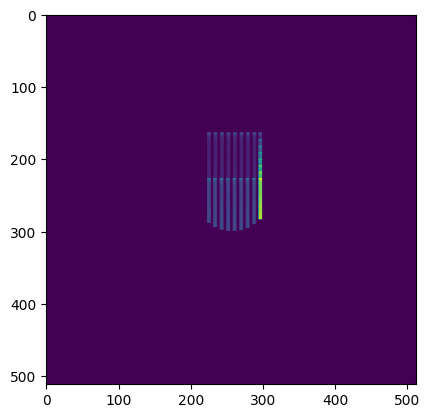

In [ ]:
print(np.max(snapshots[-1]))
plt.imshow(snapshots[-1])

PEW


/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/env_checker.py:130: UserWarning: Your observation dose distribution has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/env_checker.py:130: UserWarning: Your observation target mask has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


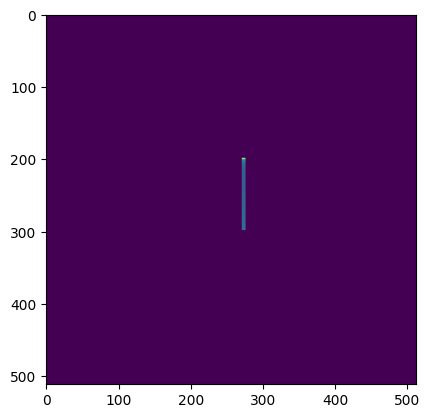

In [ ]:
env = ParallelBeamEnv()
check_env(env)
env.render()

#### Single Patient

In [ ]:
# Set it up on the first patient
env = make_vec_env(ParallelBeamEnv, n_envs=num_processers, vec_env_cls=SubprocVecEnv)
model = PPO('MultiInputPolicy', env, verbose=1, device="cuda", n_steps=1024, tensorboard_log=logdir)
model.save(f"/workspaces/MPhys Gamification/modeldir/040523_bortfeld_test")

In [ ]:
model.learn(n_timesteps, tb_log_name=f"090523_bortfeld_test")
model.save(f"/workspaces/MPhys Gamification/modeldir/090523_bortfeld_test")
del model

#### Multipatient

In [ ]:
env = make_vec_env(ParallelBeamEnv, n_envs=num_processers, vec_env_cls=SubprocVecEnv)
model = PPO('MultiInputPolicy', env, verbose=1, device="cuda", n_steps=1024, tensorboard_log=logdir)
model.save(f"/workspaces/MPhys Gamification/modeldir/040523_final_0")

In [ ]:
n_timesteps = 327680
i = 0
for patient in my_data:
    # define two contours called EXTERNAL and CANCER
    model.load(f"/workspaces/MPhys Gamification/modeldir/040523_final_{i}")
    cancer, external = load_patient(patient[0], patient[1], patient[2], patient[3], patient[4])
    env.cancer = cancer
    env.external = external
    env.reset()
    model.learn(n_timesteps, tb_log_name=f"040523_final_patient_{i}")
    model.save(f"/workspaces/MPhys Gamification/modeldir/040523_final_{i+1}")
    i += 1

del model

#### Manual Testing

In [ ]:
env = ParallelBeamEnv()
env.reset()
done = False
rewards = 0
snapshots = []
cancer_contours = []
actions = [np.array([2,2,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),
           np.array([0,0,1,1]),]
for action in actions:
    #action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    print(obs["position"])
    rewards += reward
    # Save the snapshot after each action
    snapshot = env.render(mode="rgb_array")
    cancer_contour = env.render(mode="cancer_contour")
    snapshots.append(copy.deepcopy(snapshot))
    if done == True:
        print(np.max(snapshot))
        break

print(rewards)
print(len(snapshots))
plt.imshow(snapshots[-1], origin="lower")

#### Image Testing

In [ ]:
def canvas_evaluation(model_directory: str):
    """_summary_

    Args:
        model_directory (str): Path of the model.zip file for evaluation

    Returns:
        _type_: rewards
        snapshots, cancer_contour
    """
    model = PPO.load(model_directory)
    env = ParallelBeamEnv()
    obs = env.reset()
    done = False
    rewards = 0
    snapshots = []

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards += reward

        # Save the snapshot after each action
        snapshot = env.render(mode="rgb_array")
        snapshots.append(copy.deepcopy(snapshot))
        cancer_contour = env.render(mode="cancer_contour")
    eval_score = env.evaluate_state()
    env.close()

    print(rewards)
    print(len(snapshots))
    plt.imshow(cancer_contour + snapshots[-1], origin="lower")


    return rewards, snapshots, cancer_contour, eval_score

In [ ]:
patient = my_data[-12]
cancer, external = load_patient(patient[0], patient[1], patient[2], patient[3], patient[4])

-0.2708772003600195
1025


/tmp/ipykernel_11173/2674884413.py:14: RuntimeWarning: invalid value encountered in double_scalars
  colors = [(0, 'black'), (0.01, 'blue'), (mid_val / max_val, 'white'), (1, 'red')]


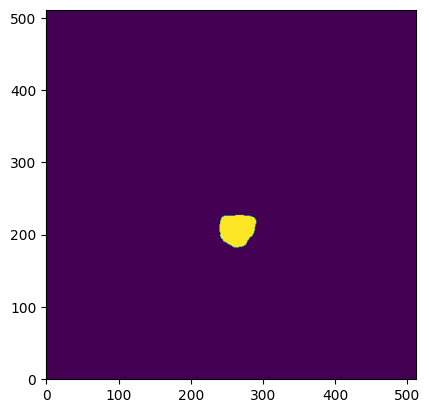

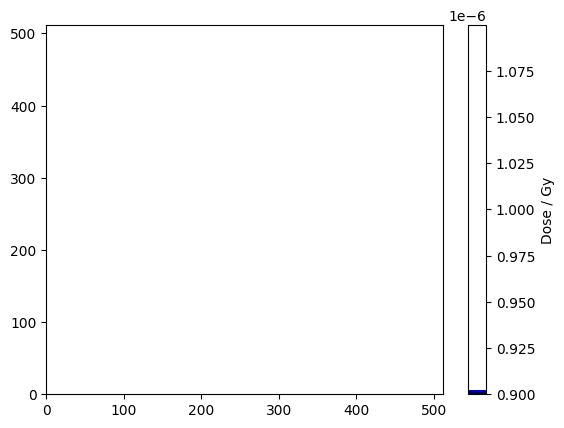

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming you have a 2D histogram array called 'hist' with shape (5112, 512)
_, snapshots, _, _ = canvas_evaluation("/workspaces/MPhys Gamification/modeldir/090523_bortfeld_test")
hist = (snapshots[-1]) # Replace this line with your actual histogram data

# Set target value and create a custom colormap
target_value = 0.7
min_val = np.min(hist)
max_val = np.max(hist)
mid_val = target_value * (max_val - min_val) + min_val
colors = [(0, 'black'), (0.01, 'blue'), (mid_val / max_val, 'white'), (1, 'red')]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)

# Modify the hist array so that zero values are set to a very small value
hist_mod = np.where(hist > 0, hist, 1e-6)

# Create the pcolormesh plot with the custom colormap
fig, ax = plt.subplots()
xedges = np.arange(0, hist.shape[1] + 1)  # xedges from 0 to 512 (shape[1] + 1)
yedges = np.arange(0, hist.shape[0] + 1)  # yedges from 0 to 5112 (shape[0] + 1)
pc = ax.pcolormesh(xedges, yedges, hist_mod.T, cmap=custom_cmap)

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax)
cbar.set_label('Dose / Gy')

# Show the plot
plt.show()

#### Hyperparameter Testing

In [ ]:
env = make_vec_env(ParallelBeamEnv, n_envs=num_processers, vec_env_cls=SubprocVecEnv)

# Define the search space
batch_sizes = [32, 64, 128]
learning_rates = [3e-4, 1e-4, 1e-3, 3e-3]

rewards = []
errs = [] 

best_reward = -np.inf
best_hyperparams = None
for batch in batch_sizes:
    for learn_rate in learning_rates:
        # Train a model with the sampled hyperparameters
        model = PPO('MultiInputPolicy', env, verbose=0, batch_size=batch, learning_rate=learn_rate, n_steps = 1024, tensorboard_log=logdir)
        model.learn(total_timesteps=300000, tb_log_name="hyperparam_search")

        # Evaluate the model
        mean_reward, stds = evaluate_policy(model, env, n_eval_episodes=10)
        rewards.append(mean_reward)
        errs.append(stds)
        
        # Update the best hyperparameters if needed
        if mean_reward > best_reward:
            best_reward = mean_reward
            best_hyperparams = {'batch_size': batch, 'learning_rate': learn_rate}

print("Best hyperparameters:", best_hyperparams)

#### Validation Tests

In [ ]:
os.chdir("/workspaces/MPhys Gamification")

reward_averages = []
reward_std = []
models = [0, 5, 10, 15, 20, 25, 30, 35]

eval_env = ParallelBeamEnv()

for index in models:
    model = PPO.load(f"/workspaces/MPhys Gamification/modeldir/040523_final_{index}.zip")
    mean_reward, std  = evaluate_policy(model, eval_env, n_eval_episodes=100)
    del model
    reward_averages.append(mean_reward)
    reward_std.append(std)

/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [ ]:
patient = my_data[-12]
cancer, external = load_patient(patient[0], patient[1], patient[2], patient[3], patient[4])

reward_averages = []
reward_std = []
models = [0, 5, 10, 15, 20, 25, 30, 35]
validation_datasets = [40, 45, 50, 55, 60, 65, 70, 75, 80]

for i in validation_datasets:
    rewards = np.array((8, 9))
    eval_env = ParallelBeamEnv()
    patient = my_data[i]
    cancer, external = load_patient(patient[0], patient[1], patient[2], patient[3], patient[4])
    eval_env.cancer = cancer
    eval_env.external = external
    eval_env.reset()
    for index in models:
        model = PPO.load(f"/workspaces/MPhys Gamification/modeldir/040523_final_{index}.zip")
        reward, std  = evaluate_policy(model, eval_env, n_eval_episodes=100)
        del model
        rewards[int(index / 5)].append(reward)
    reward_std.np.std(rewards[])